In [1]:
import pandas as pd

from modules.features import create_features
from modules.model import get_xgb_tuner
from modules.evaluation import plot_tuning, plot_errors, get_var_imp
from modules.predict import get_initial_predictions
from modules.data_uploads import DataUploader

In [2]:
# A lot of these should acually be command line args or env variables. This is a bodge.
from config import data_dir, s3_root, s3_validation_loc, model_name, sm_client

In [3]:
df = pd.read_csv("./data/SIATestDataBuildSample.psv.gz", delimiter="|", encoding="latin")
df.head()

,Accountid,Month,Number,CurrentBalance,DefaultDate,DefaultAmt,ConsistancyL3m,ConsistancyL6m,ConsistancyL12m,ConsistancyL24m,...,Band8_(45-55),Band9_(55-65),Band10_(65-85),Band11_(85-115),Band12_(115-130),Band13_(130-160),Band14_(160-500),Band15_(500+),PreviousPayments,PrevCols
0,17403627,2017-10-01 00:00:00,8,125.97,2003-05-02 00:00:00,52.33,3,6,12,20,...,No,No,No,No,No,NaN,NaN,NaN,8,8.0
1,17403627,2017-12-01 00:00:00,10,123.97,2003-05-02 00:00:00,52.33,3,6,12,22,...,No,No,No,No,No,NaN,NaN,NaN,10,10.0
2,17403627,2018-03-01 00:00:00,13,120.97,2003-05-02 00:00:00,52.33,3,6,12,24,...,No,No,No,No,No,NaN,NaN,NaN,13,13.0
3,17403627,2018-05-01 00:00:00,15,118.97,2003-05-02 00:00:00,52.33,3,6,12,24,...,No,No,No,No,No,NaN,NaN,NaN,15,15.0
4,17403627,2018-07-01 00:00:00,17,116.97,2003-05-02 00:00:00,52.33,3,6,12,24,...,No,No,No,No,No,NaN,NaN,NaN,17,17.0


In [4]:
mod_df = create_features(df)
mod_df.head()

,PropRepaid,CurrentBalance,DefaultAmt,ConsistancyL3m,ConsistancyL6m,ConsistancyL12m,ConsistancyL24m,ConsistancyHist,ColsL3m,ColsL6m,...,monthssincelastpayment,percentageofbalance,lastpaymentamount,monthstodefault,age,remainingbalance,CollectionsBandN,remainingbalbandN,balancebandN,lastpaybandN
0,0.009173,13081.56,12014.58,3,6,12,12,12,30.00,60.00,...,1,0.00076,10.00,22.0,18.0,13071.56,4,8,8,4
1,0.007124,16003.21,16884.55,3,6,12,12,12,21.00,42.00,...,1,0.00044,7.00,11.0,18.0,15996.21,3,8,8,3
2,0.039669,6983.21,9406.54,3,6,12,12,12,50.79,101.58,...,1,0.00242,16.93,18.0,17.0,6966.28,5,8,8,5
3,1.000000,328.14,685.46,2,5,10,10,10,7.24,17.02,...,1,0.00993,3.26,30.0,17.0,324.88,3,1,1,3
4,0.032273,1859.13,4290.11,3,6,12,12,12,15.00,30.00,...,1,0.00269,5.00,55.0,17.0,1854.13,3,7,8,3


In [5]:
uploader = DataUploader(mod_df)
uploader.save_local()
uploader.save_s3()
uploader.check_split()

Data Split. initial len: 5889 train_len: 4122, test_len: 1178, validation_len: 589


In [6]:
tuner = get_xgb_tuner(s3_root / 'output/', model_name)
tuner.fit({'train': uploader.s3_train_in(), 'validation': uploader.s3_test_in()}, include_cls_metadata=False)
sm_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

.....................................................................................................................................................................................................................................................!


'Completed'

In [7]:
tuner.latest_tuning_job.job_name

'aamod20200130-tuner-210131-0738'

In [8]:
#### Load previously trained tuner if you are returning after logoff.
# import sagemaker
# from config import sm_sess
# tuner_name = "aamod20200124-tuner-210130-0327" # fill with above cell's result.
# tuner = sagemaker.tuner.HyperparameterTuner.attach(tuner_name, sagemaker_session=sm_sess)
###

tune_df = tuner.analytics().dataframe()
tune_df = tune_df.sort_values("FinalObjectiveValue", ascending=True)
tune_df.head()

,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,1.195427,0.507127,1.0,7.747723,aamod20200130-tuner-210131-0738-018-d18afd50,Completed,0.177749,2021-01-31 08:01:05+00:00,2021-01-31 08:02:06+00:00,61.0
18,1.403110,0.851274,1.0,5.959149,aamod20200130-tuner-210131-0738-002-fd7dea11,Completed,0.177757,2021-01-31 07:41:00+00:00,2021-01-31 07:42:03+00:00,63.0
5,0.687370,0.669115,1.0,1.948040,aamod20200130-tuner-210131-0738-015-740119cb,Completed,0.177765,2021-01-31 07:57:20+00:00,2021-01-31 07:58:16+00:00,56.0
4,1.426606,0.488819,1.0,2.874836,aamod20200130-tuner-210131-0738-016-49ee2cb0,Completed,0.177766,2021-01-31 07:59:54+00:00,2021-01-31 08:00:43+00:00,49.0
7,1.774468,0.272600,1.0,3.915241,aamod20200130-tuner-210131-0738-013-114654d5,Completed,0.177956,2021-01-31 07:56:23+00:00,2021-01-31 07:57:26+00:00,63.0


In [9]:
print("Best RMSE: ", tune_df.reset_index().loc[0, "FinalObjectiveValue"])

Best RMSE:  0.17774899303913116


In [10]:
model_loc = s3_root / 'output/' / tuner.best_training_job() / "output/model.tar.gz"
model_loc

PureS3Path('/robtests/sagemaker/aa/output/aamod20200130-tuner-210131-0738-018-d18afd50/output/model.tar.gz')

In [11]:
validation_data = pd.read_csv(data_dir /'validation.csv')
get_var_imp(validation_data, model_loc, importance_type='weight')

[08:06:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{26: 'percentageofbalance',
 15: 'DefaultAmt',
 6: 'ColsL6m',
 7: 'CurrentBalance',
 3: 'monthssincelastpayment',
 2: 'monthssincenopay',
 4: 'AvgL12m',
 1: 'ConsistancyL12m'}

In [12]:
get_var_imp(validation_data, model_loc, importance_type='total_gain')

[08:06:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{162.92690794999996: 'percentageofbalance',
 13.221613017599998: 'remainingbalance',
 8.462959854: 'lastpaymentamount',
 4.2954012549: 'ColsL6m',
 3.0307817146000002: 'CurrentBalance',
 0.8830053656: 'CollectionsBandN',
 0.7564032337000001: 'ColsL12m',
 1.5534182706000002: 'DefaultAmt',
 0.350101448: 'ColsL3m',
 0.39445735190000003: 'AvgL12m',
 0.1837729028: 'monthstodefault',
 0.1800744444: 'age',
 0.1430153196: 'monthssincelastpayment',
 0.1140675842: 'monthssincenopay',
 0.0624443963: 'VarL12m',
 0.045721259: 'ConsistancyL3m',
 0.0291010048: 'AvgL6m',
 0.0307130869: 'ConsistancyL12m'}

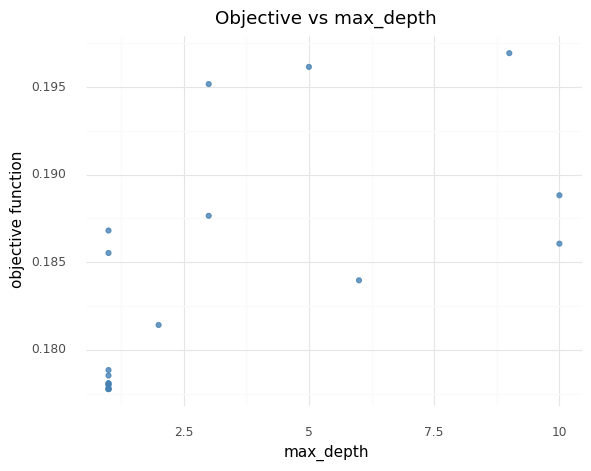

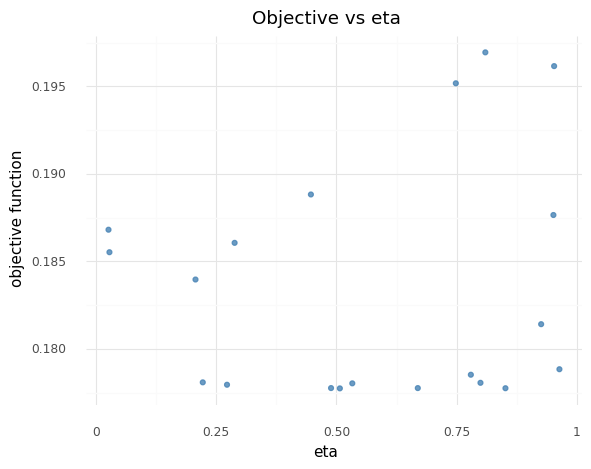

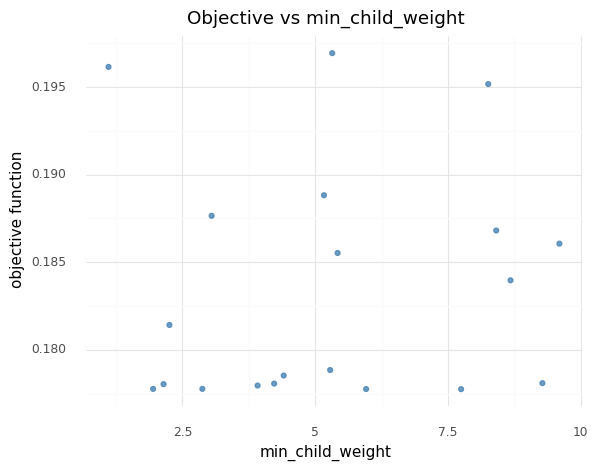

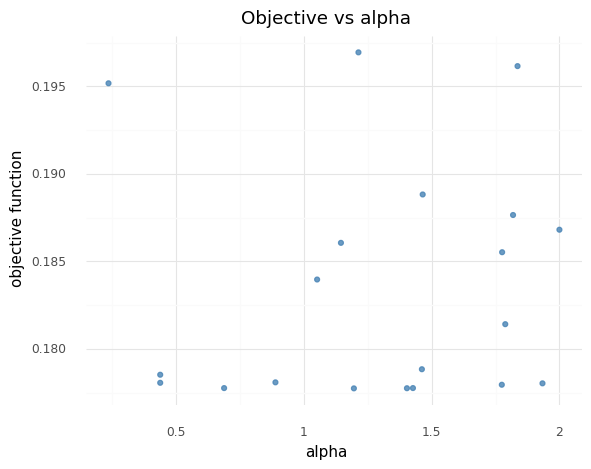

In [13]:
plot_tuning(tuner)

In [14]:
predictions = get_initial_predictions(tuner, s3_validation_loc, s3_root / 'predict_val', model_name)
predictions.head()


2021-01-31 08:02:06 Starting - Preparing the instances for training
2021-01-31 08:02:06 Downloading - Downloading input data
2021-01-31 08:02:06 Training - Training image download completed. Training in progress.
2021-01-31 08:02:06 Uploading - Uploading generated training model
2021-01-31 08:02:06 Completed - Training job completed
..........................2021-01-31T08:10:35.963:[sagemaker logs]: MaxConcurrentTransforms=2, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2021-01-31 08:10:35 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2021-01-31 08:10:35 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-01-31 08:10:35 +0000] [1] [INFO] Using worker: gevent
[2021-01-31 08:10:35 +0000] [37] [INFO] Booting worker with pid: 37
[2021-01-31 08:10:35 +0000] [38] [INFO] Booting worker with pid: 38
[2021-01-31:08:10:35:INFO] Model loaded successfully for worker : 37
[2021-01-31:08:10:35:INFO] Model loaded successfully for worker : 38
[2021-01-31:08:10:36:INFO] Sniff

,0
0,0.082482
1,0.263836
2,0.030014
3,0.055412
4,0.173937


validation_data['predictions'] = predictions[0]
validation_data['err'] = validation_data.predictions - validation_data.PropRepaid 

c:\workspace\python\python37\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 120'. Pick better value with 'binwidth'.


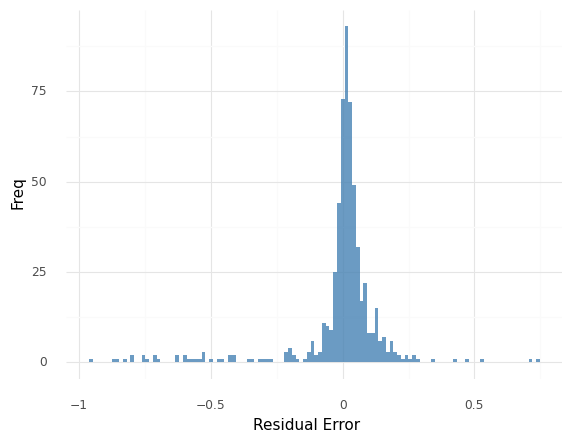

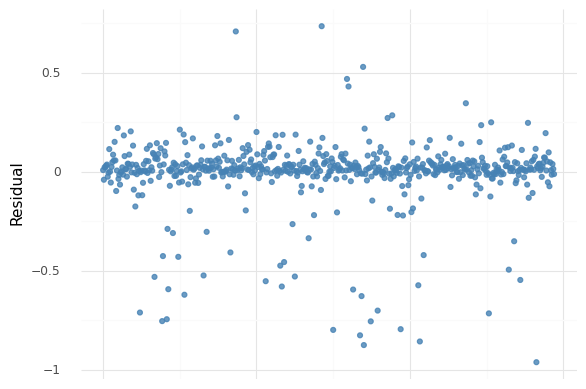

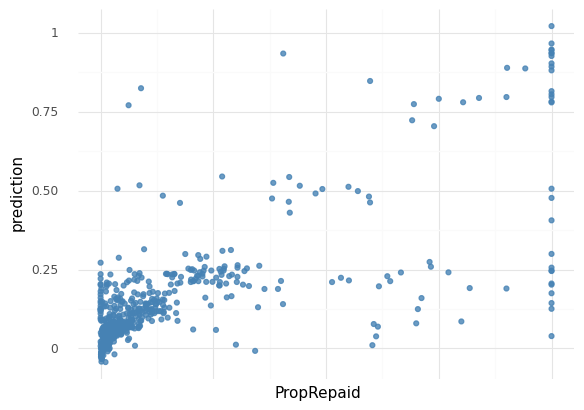

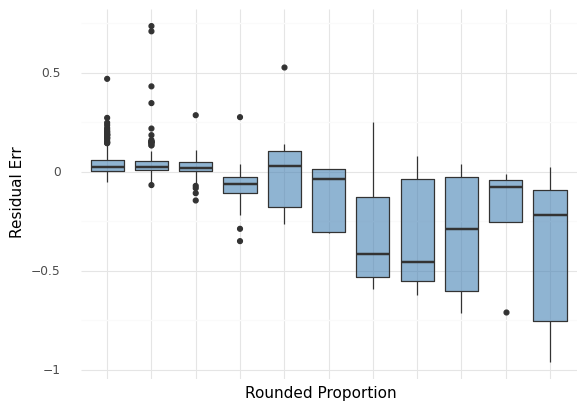

In [15]:
# validation_data = pd.read_csv(data_dir / 'validation.csv')
plot_errors(validation_data, predictions)